In [14]:
import numpy as np 

import pandas as pd

model_fig_names = {
    'llama-3.1-8b-instruct-turbo': 'Llama 3.1 8B it',
    'llama-3.1-70b-instruct-turbo': 'Llama 3.1 70B it',
    'gpt-4o': 'gpt-4o',
    'Gemma 2 27B': 'Gemma 2 27B',
    "Gemma 2 9b": "Gemma 2 9B"
}

In [4]:
model_name = 'llama-3.1-8b-instruct-turbo'
model_name = 'llama-3.1-70b-instruct-turbo' # 'Gemma 2 9b'
model_name = 'gpt-4o'
model_name = 'Gemma 2 27B'
model_name = "Gemma 2 9b"

In [6]:
merge = metadata.merge(pd.DataFrame(embs), left_index=True, right_index=True)

In [100]:
from sklearn.metrics.pairwise import cosine_similarity

# group_similarities = {}

# grouped = metadata.groupby(['story', 'language', 'suffix'])

# for name, group in grouped:
#     indices = group.index.values
#     if len(indices) > 1:  # Only calculate if group has more than 1 element
#         group_embs = embs[indices]
#         # Calculate pairwise cosine similarities
#         similarities = cosine_similarity(group_embs)
#         # Get upper triangle values (excluding diagonal)
#         upper_tri = similarities[np.triu_indices_from(similarities, k=1)]
#         # Store average similarity
#         group_similarities[name] = np.mean(upper_tri)

# # Convert results to DataFrame
# results = pd.DataFrame([
#     {'story': k[0], 'language': k[1], 'suffix': k[2], 'avg_similarity': v}
#     for k, v in group_similarities.items()
# ])

In [101]:
group_similarities = {}

grouped = metadata.groupby(['language','suffix'])

for name, group in grouped:
    indices = group.index.values
    if len(indices) > 1:  # Only calculate if group has more than 1 element
        group_embs = embs[indices]
        # Calculate pairwise cosine similarities
        similarities = cosine_similarity(group_embs)
        # Get upper triangle values (excluding diagonal)
        upper_tri = similarities[np.triu_indices_from(similarities, k=1)]
        # Store average similarity
        group_similarities[name] = np.mean(upper_tri)

# Convert results to DataFrame
results_full = pd.DataFrame([
    {'language': k[0], 'suffix': k[1], 'avg_similarity': v}
    for k, v in group_similarities.items()
])

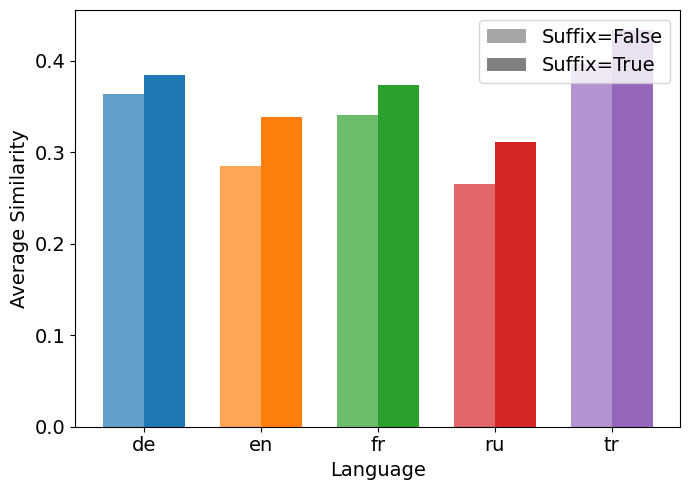

In [102]:
# Create the side-by-side bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))

# Get the data in the right format
plot_data = results_full.copy()
languages = plot_data['language'].unique()
x = np.arange(len(languages))
width = 0.35

# Colors for each language
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Create bars
for i, lang in enumerate(languages):
    lang_data = plot_data[plot_data['language'] == lang]
    false_val = lang_data[lang_data['suffix'] == False]['avg_similarity'].values[0]
    true_val = lang_data[lang_data['suffix'] == True]['avg_similarity'].values[0]
    
    plt.bar(x[i] - width/2, false_val, width, color=colors[i], alpha=0.7, label=lang)
    plt.bar(x[i] + width/2, true_val, width, color=colors[i], alpha=1.0)

# Customize the plot
plt.xlabel('Language', fontsize=14)
plt.ylabel('Average Similarity', fontsize=14)
# plt.title('Average Similarities by Language and Suffix')
plt.xticks(x, languages, fontsize=14)
plt.yticks(fontsize=14)
plt.legend()

# Add a custom legend for True/False
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gray', alpha=0.7, label='Suffix=False'),
    Patch(facecolor='gray', alpha=1.0, label='Suffix=True')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=14)

plt.tight_layout()
plt.savefig('visuals/avg_similarity_by_language_and_suffix.pdf', dpi=300, bbox_inches='tight')
plt.show()


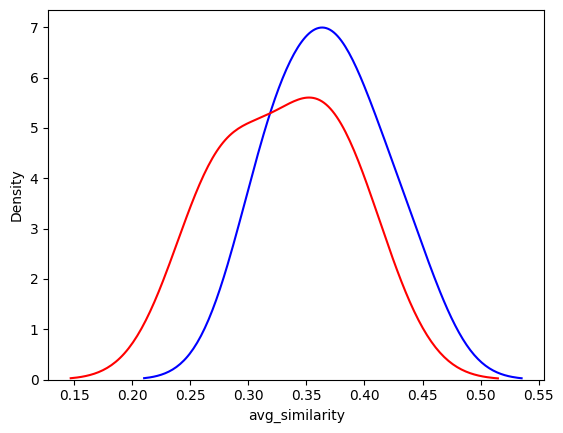

In [103]:
import seaborn as sns
d1 = results_full[results_full['suffix'] == True]
d2 = results_full[results_full['suffix'] == False]
sns.kdeplot(d1['avg_similarity'], label='Suffix=True', color='blue')
sns.kdeplot(d2['avg_similarity'], label='Suffix=False', color='red')
plt.show()

In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed

# Function to compute bootstrap average similarity for one group of normalized embeddings
def bootstrap_avg(normalized_embs, n_boot=100):
    n_samples = len(normalized_embs)
    boot_avgs = np.empty(n_boot)
    for i in range(n_boot):
        # Sample indices with replacement
        sample_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        sample_embs = normalized_embs[sample_indices]
        # Cosine similarity via dot product because embeddings are normalized
        sim = np.dot(sample_embs, sample_embs.T)
        # Extract upper-triangular (excluding diagonal)
        upper_tri = sim[np.triu_indices_from(sim, k=1)]
        boot_avgs[i] = np.mean(upper_tri)
    boot_mean = np.mean(boot_avgs)
    boot_std = np.std(boot_avgs)
    ci_lower = np.percentile(boot_avgs, 2.5)
    ci_upper = np.percentile(boot_avgs, 97.5)
    return boot_mean, boot_std, ci_lower, ci_upper

# We'll parallelize over groups, which are independent.
def process_group(name, group, model_name):
    indices = group.index.values
    if len(indices) > 1:  # Only calculate if group has more than 1 element
        group_embs = embs[indices]
        # Precompute norms and normalize embeddings for faster cosine similarity (dot product)
        norms = np.linalg.norm(group_embs, axis=1, keepdims=True)
        normalized_embs = group_embs / np.clip(norms, a_min=1e-10, a_max=None)
        
        # Original similarity using cosine_similarity (or dot product on normalized embeddings)
        sim = np.dot(normalized_embs, normalized_embs.T)
        upper_tri = sim[np.triu_indices_from(sim, k=1)]
        original_avg = np.mean(upper_tri)
        
        boot_mean, boot_std, ci_lower, ci_upper = bootstrap_avg(normalized_embs, n_boot)
        
        return {
            'language': name[0],
            'suffix': name[1],
            'original_avg': original_avg,
            'bootstrap_mean': boot_mean,
            'bootstrap_std': boot_std,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'model_name': model_name
        }
    return None


model_names = ['llama-3.1-8b-instruct-turbo', 'llama-3.1-70b-instruct-turbo', 'gpt-4o', 'Gemma 2 27B', "Gemma 2 9b"]
# Number of bootstrap iterations

all_data = pd.DataFrame()
for model_name in model_names:
    embs = np.load(f'data/embeddings/{model_name}/embeddings.npy')
    metadata = pd.read_csv(f'data/embeddings/{model_name}/metadata.csv')
    n_boot = 100

    grouped = metadata.groupby(['language', 'suffix'])
    results = []


    # Use joblib.Parallel to process each group in parallel
    results_list = Parallel(n_jobs=-1)(
        delayed(process_group)(name, group, model_name) for name, group in grouped
    )

    # Filter out groups that returned None (because they had only one element)
    results_list = [r for r in results_list if r is not None]

    # Convert results to DataFrame
    results2 = pd.DataFrame(results_list)
    all_data = pd.concat([all_data, results2])

In [27]:
all_data['model_name'] = all_data['model_name'].map(model_fig_names)

In [47]:
all_data2 = all_data.groupby(['model_name', 'suffix'])[['bootstrap_mean', 'ci_lower', 'ci_upper', 'bootstrap_std']].mean().reset_index()
all_data2['avg_with_ci'] = all_data2.apply(
    lambda row: f"{row['bootstrap_mean']:.3f} $\pm$ {2*row['bootstrap_std']:.3f}",
    axis=1
)
all_data2['avg_with_ci'] = all_data2['avg_with_ci'].str.replace('$\pm$', '\\tiny{$\pm$') + '}'
all_data2 = all_data2.pivot(index='model_name', columns='suffix', values='avg_with_ci')
all_data2.columns=['Implicit', 'Explicit']
all_data2.to_latex(f'latex/avg_similarity_by_model_and_suffix.tex', escape=False)

In [53]:
for model_name in model_names:
    all_data2 = all_data[all_data['model_name'] == model_fig_names[model_name]]
    all_data2 = all_data2.groupby(['language', 'suffix'])[['bootstrap_mean', 'ci_lower', 'ci_upper', 'bootstrap_std']].mean().reset_index()
    all_data2['avg_with_ci'] = all_data2.apply(
        lambda row: f"{row['bootstrap_mean']:.3f} $\pm$ {2*row['bootstrap_std']:.3f}",
        axis=1
    )
    all_data2['avg_with_ci'] = all_data2['avg_with_ci'].str.replace('$\pm$', '\\tiny{$\pm$') + '}'
    all_data2 = all_data2.pivot(index='language', columns='suffix', values='avg_with_ci')
    all_data2.columns=['Implicit', 'Explicit']
    all_data2.to_latex(f'latex/{model_name}.tex', escape=False)